# <center>CSIS 753 - Machine Learning</center>

## Real or Not? NLP with Disaster Tweets

This is part of the Machine Learning cource requirements and being delivered as a project to showcase learning developments from the cource.
The project "Real or Not? NLP with Disaster Tweets" is part of the Kaggle challenge to develop a ML model to identify and predict which Tweets are about real disasters and which one’s aren’t. 


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
import keras
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDClassifier, SGDRegressor 
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import LazyCorpusLoader


random_seed = 1
np.random.seed(random_seed)
np.set_printoptions(precision=2)

Using TensorFlow backend.


### Import Data

The data file "train.scv" has been already downloaded to the project folder and we will import the same for running the project.

In [2]:
data_set_train = pd.read_csv("train.csv")
print("Number of records in Train data set",len(data_set_train.index))
data_set_train.head()

Number of records in Train data set 7613


id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

### Generate data info

In [3]:
data_set_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### The dataset includes columns:
    1. id ( unique identifier )
	2. keyword ( from respective tweet )
	3. location ( that tweet sent from )
	4. text ( the actual tweet)
	5. target - the label we want to predict ( 0 = non-disaster , 1 = disaster )

In [4]:
# Finding the missing records in the features

data_set_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

It is evident that some of the values from "keyword" and "location" columns are missing and this could be that data is not clean as there are too many incoorect and missing values. let us findout how the data is linedup.

In [5]:
train_set_numeric = data_set_train.drop(columns=["keyword", "location","text"], axis=1)
train_set_numeric.info()
train_set_cat = data_set_train.drop(columns=["id","target"], axis=1)
train_set_cat.info()
train_set_text = data_set_train["text"].copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      7613 non-null   int64
 1   target  7613 non-null   int64
dtypes: int64(2)
memory usage: 119.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
dtypes: object(3)
memory usage: 178.6+ KB


In [6]:
train_set_cat["keyword"].value_counts()
missing_keyword = pd.isnull(train_set_cat['keyword'])
# filtering data  
# displaying data without Keywords = NaN
print("Number of records with missing keywords",len(train_set_cat[missing_keyword]))
print( '{}% of Kewords are missing from Total Number of Records'
      .format((len(train_set_cat[missing_keyword])/len(train_set_cat.index))*100))
print("-----------------------------------------------------")
print(train_set_cat["keyword"].value_counts())

Number of records with missing keywords 61
0.8012610009194797% of Kewords are missing from Total Number of Records
-----------------------------------------------------
fatalities               45
armageddon               42
deluge                   42
sinking                  41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64


In [7]:
# filtering data
train_set_cat["location"].value_counts()
missing_location = pd.isnull(train_set_cat['location'])

print("Number of records with missing location",len(train_set_cat[missing_location]))
print( '{}% of location are missing from Total Number of Records'
      .format((len(train_set_cat[missing_location])/len(train_set_cat.index))*100))
print("-----------------------------------------------------")
print(train_set_cat["location"].value_counts())

Number of records with missing location 2533
33.27203467752528% of location are missing from Total Number of Records
-----------------------------------------------------
USA                               104
New York                           71
United States                      50
London                             45
Canada                             29
                                 ... 
israel                              1
Xi'an, China                        1
Fashion Heaven. IG: TMId_           1
Live Oak, TX                        1
Stamford & Cork (& Shropshire)      1
Name: location, Length: 3341, dtype: int64


From the above analysis we can conclude that:

    1. Location feature has many missing data and it is user entered data and not automatically generated. This data is not clean and not worth persueing for further analysis as the missong percentage is more than 33%.
    
    2. On the other hand "keyword" data is missong data, however the missing percentage is very minimal (<1%). It may be worth using it.

In [8]:
#dropping unwanted column 'location'

data_set_train = data_set_train.drop(['location'],axis=1)
data_set_train.head()

id keyword                                               text  target
0   1     NaN  Our Deeds are the Reason of this #earthquake M...       1
1   4     NaN             Forest fire near La Ronge Sask. Canada       1
2   5     NaN  All residents asked to 'shelter in place' are ...       1
3   6     NaN  13,000 people receive #wildfires evacuation or...       1
4   7     NaN  Just got sent this photo from Ruby #Alaska as ...       1

In [9]:
# printing the records after dropping location

print("Number of records in train set",len(data_set_train))
print( '{}% of location are missing from Total Number of Records'
      .format((len(train_set_cat[missing_keyword])/len(train_set_cat.index))*100))
print("-----------------------------------------------------")
data_set_train.info()

Number of records in train set 7613
0.8012610009194797% of location are missing from Total Number of Records
-----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       7613 non-null   int64 
 1   keyword  7552 non-null   object
 2   text     7613 non-null   object
 3   target   7613 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 238.0+ KB


Considering that we still have some data missing we can drop the missing keword records from our train set.

In [10]:
#dropping missing 'keyword' records from train data set
data_set_train = data_set_train.drop(data_set_train[missing_keyword].index, axis=0)

#Resetting the index after droping the missing records
data_set_train=data_set_train.reset_index(drop=True)

print("Number of records in train set",len(data_set_train))

data_set_train.head()

Number of records in train set 7552


id keyword                                               text  target
0  48  ablaze  @bbcmtd Wholesale Markets ablaze http://t.co/l...       1
1  49  ablaze  We always try to bring the heavy. #metal #RT h...       0
2  50  ablaze  #AFRICANBAZE: Breaking news:Nigeria flag set a...       1
3  52  ablaze                 Crying out for more! Set me ablaze       0
4  53  ablaze  On plus side LOOK AT THE SKY LAST NIGHT IT WAS...       0

Now that we have removed missing data and removed large inappropriate data of location we can now concentrate on "text" column to make a scensible data out of it. in order to make scence of the "text" column we need to perform several actions so that the machine can understand user texts and then we can build models to findout if the tweets were disaster or not.

In [11]:
# check class distribution

print("No. of Real Disaster Tweets (Target = 1):",len(data_set_train[data_set_train["target"]==1]))
print("No. of Fake Disaster Tweets (Target = 0):",len(data_set_train[data_set_train["target"]==0]))

No. of Real Disaster Tweets (Target = 1): 3229
No. of Fake Disaster Tweets (Target = 0): 4323


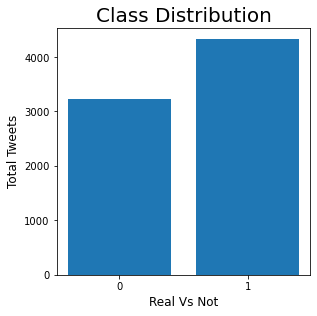

In [12]:
# Following is the visualizisation of the class distribution

def bar_plot(category,length,xlabel,ylabel,title,sub):
    plt.subplot(2,2,sub)
    plt.bar(category, length)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=20)
    plt.show()

plt.figure(figsize = (10,10))
bar_plot(["0","1"],[len(data_set_train[data_set_train.target==1]), len(data_set_train[data_set_train.target==0])],"Real Vs Not","Total Tweets","Class Distribution",1)


The number of casual tweets are more than Real disaster tweets which are denoted as 0 and 1 respectively.

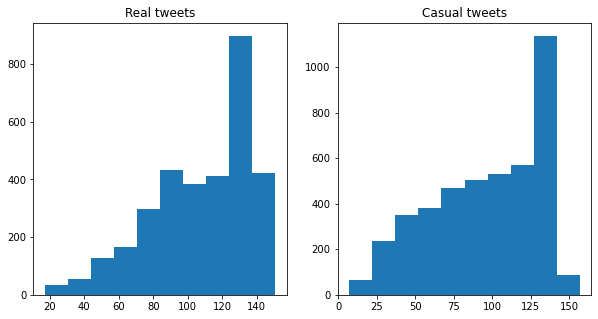

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

tlen=data_set_train[data_set_train['target']==1]['text'].str.len()
ax1.hist(tlen)
ax1.set_title('Real tweets')

tlen=data_set_train[data_set_train['target']==0]['text'].str.len()
ax2.hist(tlen)
ax2.set_title('Casual tweets')

plt.show()

Maximum length of tweets of Disastrous tweets and Non-Disastrous tweets lie between 120-150.

## Data Cleaning

In [14]:
# A quick glance over the existing data
data_set_train['text'][:5]

0    @bbcmtd Wholesale Markets ablaze http://t.co/l...
1    We always try to bring the heavy. #metal #RT h...
2    #AFRICANBAZE: Breaking news:Nigeria flag set a...
3                   Crying out for more! Set me ablaze
4    On plus side LOOK AT THE SKY LAST NIGHT IT WAS...
Name: text, dtype: object

In [15]:
# !pip install tweet-preprocessor is needed for the first time

import preprocessor as p

def preprocess_tweet(row):
    text = row['text']
    text = p.clean(text)
    return text

data_set_train['text'] = data_set_train.apply(preprocess_tweet, axis=1)
data_set_train.head()



id keyword                                               text  target
0  48  ablaze                           Wholesale Markets ablaze       1
1  49  ablaze                  We always try to bring the heavy.       0
2  50  ablaze    : Breaking news:Nigeria flag set ablaze in Aba.       1
3  52  ablaze                 Crying out for more! Set me ablaze       0
4  53  ablaze  On plus side LOOK AT THE SKY LAST NIGHT IT WAS...       0

In [16]:
#!pip install gensim
from gensim.parsing.preprocessing import remove_stopwords

def stopword_removal(row):
    text = row['text']
    text = remove_stopwords(text)
    return text

data_set_train['text'] = data_set_train.apply(stopword_removal, axis=1)
data_set_train.head()

id keyword                                              text  target
0  48  ablaze                          Wholesale Markets ablaze       1
1  49  ablaze                               We try bring heavy.       0
2  50  ablaze      : Breaking news:Nigeria flag set ablaze Aba.       1
3  52  ablaze                           Crying more! Set ablaze       0
4  53  ablaze  On plus LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE       0

In [17]:
data_set_train['text'] = data_set_train['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')
data_set_train.head()

id keyword                                              text  target
0  48  ablaze                          wholesale markets ablaze       1
1  49  ablaze                               we try bring heavy        0
2  50  ablaze        breaking news nigeria flag set ablaze aba        1
3  52  ablaze                            crying more set ablaze       0
4  53  ablaze  on plus look at the sky last night it was ablaze       0

In [18]:
ps=PorterStemmer()
wn=WordNetLemmatizer()
corpus=[]
stopwords=set(stopwords.words('english'))

for i in range(0, len(data_set_train)):

    review = re.sub('[^a-zA-Z]', ' ', data_set_train['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [wn.lemmatize(word) for word in review if word not in stopwords]
    review = ' '.join(review)
    corpus.append(review)
    
corpus[1]

'try bring heavy'

## Building Vectors

Using Count Vectorizer we can now build features that will help us build a success model. we will use the Text to build features. The words available in the tweets are a good indicator if they contain real disaster or not.

In [19]:
# Use the tweet data to turn them to features
count_vectorizer = feature_extraction.text.CountVectorizer()

# fit the data and convert sparse matrix to a dense matrix
train_vectorizer = count_vectorizer.fit_transform(corpus).toarray()
print(len(train_vectorizer))
print(train_vectorizer.shape)
train_vectorizer[:5]

7552
(7552, 11659)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## Train and Test Data
Train and test data required for us build a successful model and the below ste will help us with that.

In [20]:
X = train_vectorizer
y = data_set_train.target

# Create Train and Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

target_names=set(data_set_train['target'].values)
print(target_names)

print("X shape:", X.shape, "X_train shape:", X_train.shape, 
      "X_test shape:", X_test.shape,"X_val shape:", X_val.shape, y_train.shape)

{0, 1}
X shape: (7552, 11659) X_train shape: (6116, 11659) X_test shape: (756, 11659) X_val shape: (680, 11659) (6116,)


## Model building

The below step will start building a classification model and in the future steps we will look at neural network.

In [21]:
model = SGDClassifier(learning_rate ='adaptive', eta0=0.1, max_iter=500, tol=0.1, random_state=1, loss='log')
model.fit(X_train, y_train.squeeze())
h_train = model.predict(X_train)
h_test = model.predict(X_test)
ca_train = accuracy_score(np.squeeze(y_train), h_train)
ca_test = accuracy_score(np.squeeze(y_test), h_test)
print("Training Accuracy: {0:0.2%}".format(ca_train))
print("Y_test:", np.squeeze(y_test))
print("h_test:", h_test)
print("Test Accuracy: {0:0.2%}".format(ca_test))

Training Accuracy: 93.18%
Y_test: 2415    1
2196    0
5724    0
1297    0
6747    0
       ..
2040    1
7096    1
5083    1
6999    1
218     1
Name: target, Length: 756, dtype: int64
h_test: [1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0
 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0
 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 1
 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0
 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0
 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1
 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1

In [22]:
from sklearn.metrics import confusion_matrix

cf_test = confusion_matrix(y_test, h_test)
print("Y_test:", np.squeeze(y_test))
print("h_test:", h_test)
print("Test Confusion Matrix:\n", cf_test)

Y_test: 2415    1
2196    0
5724    0
1297    0
6747    0
       ..
2040    1
7096    1
5083    1
6999    1
218     1
Name: target, Length: 756, dtype: int64
h_test: [1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0
 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0
 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 1
 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0
 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0
 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1
 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1
 0 1 0 1 

In [23]:
#  finding the Precision and Recall of the model

from sklearn.metrics import precision_score, recall_score
ps = precision_score(y_test, h_test) 
rs = recall_score(y_test, h_test)
print("Precision: {0:0.2%}".format(ps))
print("Recall:    {0:0.2%}".format(rs))

Precision: 81.57%
Recall:    64.40%


In [24]:
# finding the F1 score

from sklearn.model_selection import cross_val_score

f1_scores = cross_val_score(model, X_train, y_train.squeeze(), scoring='f1', cv=5)
print("CV F1 scores: ", f1_scores)
print("Average F1: {0:0.2%}".format(np.mean(f1_scores)))

CV F1 scores:  [0.75 0.71 0.74 0.72 0.72]
Average F1: 72.80%


In [25]:
# predecting the best params
from sklearn.model_selection import GridSearchCV

model = SGDClassifier(tol=0.1, random_state=1, loss='log')
param_grid = [
                {'learning_rate': ['invscaling', 'adaptive'],
                 'eta0': [0.01, 0.1, 0.2, 0.3], 
                 'max_iter': [100, 200, 300, 400],
                }
]

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', refit=True)
grid_search.fit(X_train, y_train.squeeze())
print(grid_search.best_params_)

{'eta0': 0.1, 'learning_rate': 'adaptive', 'max_iter': 100}


In [26]:
best_model = grid_search.best_estimator_
h_test = best_model.predict(X_test)

ca = accuracy_score(np.squeeze(y_test), h_test)
cf = confusion_matrix(y_test, h_test)
ps = precision_score(y_test, h_test) 
rs = recall_score(y_test, h_test)
f1 = f1_score(y_test, h_test)

print(">>>>>>>>>> Test Performance <<<<<<<<<")
print("Accuracy: {0:0.2%}".format(ca))
print("Confusion Matrix:\n", cf)
print("Precision: {0:0.2%}".format(ps))
print("Recall:    {0:0.2%}".format(rs))
print("F1:        {0:0.2%}".format(f1))

>>>>>>>>>> Test Performance <<<<<<<<<
Accuracy: 78.57%
Confusion Matrix:
 [[386  47]
 [115 208]]
Precision: 81.57%
Recall:    64.40%
F1:        71.97%


## Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
h_train = tree.predict(X_train)
h_test = tree.predict(X_test)
print(y_test[0:10])
print(h_test[0:10])

2415    1
2196    0
5724    0
1297    0
6747    0
4942    1
7245    0
2378    1
7277    1
444     1
Name: target, dtype: int64
[1 0 0 0 0 0 0 0 1 1]


In [28]:
from sklearn.metrics import classification_report
ca_train = accuracy_score(y_train,h_train)
cf_train = confusion_matrix(y_train,h_train)
print("Train Performance")
print("Average Train Accuracy: {0:0.2%}".format(ca_train))
print("Average Train Confusion Matrix:\n",cf_train)
print(classification_report(y_train,h_train))

ca_test = accuracy_score(y_test,h_test)
cf_test = confusion_matrix(y_test,h_test)
print("\n\nTest Performance")
print("Average Test Accuracy: {0:0.2%}".format(ca_test))
print("Average Test Confusion Matrix:\n",cf_test)
print(classification_report(y_test,h_test))

Train Performance
Average Train Accuracy: 98.33%
Average Train Confusion Matrix:
 [[3511    9]
 [  93 2503]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3520
           1       1.00      0.96      0.98      2596

    accuracy                           0.98      6116
   macro avg       0.99      0.98      0.98      6116
weighted avg       0.98      0.98      0.98      6116



Test Performance
Average Test Accuracy: 73.54%
Average Test Confusion Matrix:
 [[334  99]
 [101 222]]
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       433
           1       0.69      0.69      0.69       323

    accuracy                           0.74       756
   macro avg       0.73      0.73      0.73       756
weighted avg       0.74      0.74      0.74       756



In [29]:
RF=RandomForestClassifier()
RF.fit(X_train,y_train)
h_train = RF.predict(X_train)
h_test = RF.predict(X_test)
print(y_test[0:10])
print(h_test[0:10])

2415    1
2196    0
5724    0
1297    0
6747    0
4942    1
7245    0
2378    1
7277    1
444     1
Name: target, dtype: int64
[1 0 0 0 0 0 0 0 1 1]


In [30]:
ca_train = accuracy_score(y_train,h_train)
cf_train = confusion_matrix(y_train,h_train)
print("Train Performance")
print("Average Train Accuracy: {0:0.2%}".format(ca_train))
print("Average Train Confusion Matrix:\n",cf_train)
print(classification_report(y_train,h_train))

ca_test = accuracy_score(y_test,h_test)
cf_test = confusion_matrix(y_test,h_test)
print("\n\nTest Performance")
print("Average Test Accuracy: {0:0.2%}".format(ca_test))
print("Average Test Confusion Matrix:\n",cf_test)
print(classification_report(y_test,h_test))

Train Performance
Average Train Accuracy: 98.33%
Average Train Confusion Matrix:
 [[3489   31]
 [  71 2525]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3520
           1       0.99      0.97      0.98      2596

    accuracy                           0.98      6116
   macro avg       0.98      0.98      0.98      6116
weighted avg       0.98      0.98      0.98      6116



Test Performance
Average Test Accuracy: 74.87%
Average Test Confusion Matrix:
 [[347  86]
 [104 219]]
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       433
           1       0.72      0.68      0.70       323

    accuracy                           0.75       756
   macro avg       0.74      0.74      0.74       756
weighted avg       0.75      0.75      0.75       756



In [31]:
s=svm.SVC(decision_function_shape='ovo',gamma='auto')
s.fit(X_train,y_train)
h_train = s.predict(X_train)
h_test = s.predict(X_test)
print(y_test[0:10])
print(h_test[0:10])

2415    1
2196    0
5724    0
1297    0
6747    0
4942    1
7245    0
2378    1
7277    1
444     1
Name: target, dtype: int64
[0 0 0 0 0 0 0 0 0 0]


In [32]:
ca_train = accuracy_score(y_train,h_train)
cf_train = confusion_matrix(y_train,h_train)
print("Train Performance")
print("Average Train Accuracy: {0:0.2%}".format(ca_train))
print("Average Train Confusion Matrix:\n",cf_train)
print(classification_report(y_train,h_train))

ca_test = accuracy_score(y_test,h_test)
cf_test = confusion_matrix(y_test,h_test)
print("\n\nTest Performance")
print("Average Test Accuracy: {0:0.2%}".format(ca_test))
print("Average Test Confusion Matrix:\n",cf_test)
print(classification_report(y_test,h_test))

Train Performance
Average Train Accuracy: 57.55%
Average Train Confusion Matrix:
 [[3520    0]
 [2596    0]]
              precision    recall  f1-score   support

           0       0.58      1.00      0.73      3520
           1       0.00      0.00      0.00      2596

    accuracy                           0.58      6116
   macro avg       0.29      0.50      0.37      6116
weighted avg       0.33      0.58      0.42      6116



Test Performance
Average Test Accuracy: 57.28%
Average Test Confusion Matrix:
 [[433   0]
 [323   0]]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       433
           1       0.00      0.00      0.00       323

    accuracy                           0.57       756
   macro avg       0.29      0.50      0.36       756
weighted avg       0.33      0.57      0.42       756



C:\Users\2ksan\.conda\envs\MLPY36TF2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Shallow Neural Network

Further to this analysis we will use the Shallow network to findout if we can get best results.

In [33]:
import tensorflow as tf
import sklearn as skl
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import losses
from keras import metrics
from tensorflow.keras import initializers
from keras import backend as K

#clean up memory
keras.backend.clear_session()

#set random seeds for reproducable results
experiments_seed = 1
np.random.seed(experiments_seed)
tf.random.set_seed(experiments_seed)

In [34]:
#normalize the data
scaler = skl.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


print("X_train shape:\t", X_train.shape, "\n")
print("X_test shape:\t", X_test.shape, "\n")

X_train shape:	 (6116, 11659) 

X_test shape:	 (756, 11659) 



In [41]:
from tensorflow.keras.callbacks import EarlyStopping

#funtion to help build a model
def build_model(n):
    model = Sequential()
    model.add(Dense(1024, activation='tanh', input_shape=(n,)))
    model.add(Dense(512, activation='tanh'))
    model.add(Dense(256, activation='tanh'))
    model.add(Dense(128, activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.Adadelta(lr=0.03),
                  loss=losses.binary_crossentropy,
                  metrics=["accuracy"])
    return model

model = build_model(X_train.shape[1])

# using the early stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta = 0.001, patience=10) 

callbacks_list = [early_stopping]

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=10,
                    callbacks=callbacks_list,
                    verbose = 1)

Train on 6116 samples, validate on 680 samples
Epoch 1/50
6116/6116 [==============================] - 33s 5ms/step - loss: 0.6362 - accuracy: 0.6306 - val_loss: 0.6473 - val_accuracy: 0.5941
Epoch 2/50
6116/6116 [==============================] - 38s 6ms/step - loss: 0.4730 - accuracy: 0.7951 - val_loss: 0.6012 - val_accuracy: 0.6529
Epoch 3/50
6116/6116 [==============================] - 35s 6ms/step - loss: 0.3599 - accuracy: 0.8635 - val_loss: 0.6117 - val_accuracy: 0.6618
Epoch 4/50
6116/6116 [==============================] - 34s 6ms/step - loss: 0.2820 - accuracy: 0.8990 - val_loss: 0.5996 - val_accuracy: 0.6868
Epoch 5/50
6116/6116 [==============================] - 34s 6ms/step - loss: 0.2255 - accuracy: 0.9292 - val_loss: 0.6093 - val_accuracy: 0.6956
Epoch 6/50
6116/6116 [==============================] - 34s 6ms/step - loss: 0.1842 - accuracy: 0.9483 - val_loss: 0.6306 - val_accuracy: 0.7015
Epoch 7/50
6116/6116 [==============================] - 35s 6ms/step - loss: 0.1566

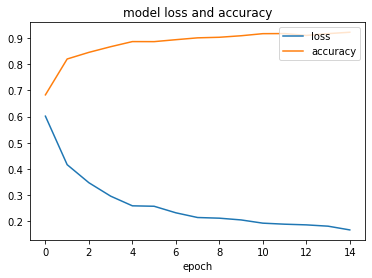

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss and accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper right')
plt.show()

In [37]:
#testing the model
p_test = model.predict(X_test) #get the output activations (probabilities)
h_test = np.array([int(elem) for elem in p_test>0.5]) #Convert probabilities to class labels)

np.set_printoptions(precision=2, suppress=True)
print("Output Activations: ", np.squeeze(p_test[0:10]))
print("Predicted Output  : ", np.squeeze(h_test[0:10]))
print("Actual Output     : ", np.squeeze(y_test[0:10]))

Output Activations:  [0.98 0.93 0.02 0.02 0.02 0.02 0.02 0.98 0.98 0.02]
Predicted Output  :  [1 1 0 0 0 0 0 1 1 0]
Actual Output     :  2415    1
2196    0
5724    0
1297    0
6747    0
4942    1
7245    0
2378    1
7277    1
444     1
Name: target, dtype: int64


In [43]:
#model performance
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

p_train = model.predict(X_train) 
h_train = np.array([int(elem) for elem in p_train>0.5]) 
p_test = model.predict(X_test) 
h_test = np.array([int(elem) for elem in p_test>0.5]) 

ca_train = accuracy_score(np.squeeze(y_train), np.squeeze(h_train))
ca_test = accuracy_score(np.squeeze(y_test), np.squeeze(h_test))

print("Training Accuracy: {0:0.2%}".format(ca_train))
print("Test Accuracy: {0:0.2%}".format(ca_test))

cf_test = confusion_matrix(y_test, h_test)
ps_test = precision_score(y_test, h_test) 
rs_test = recall_score(y_test, h_test)
f1_test = f1_score(y_test, h_test)

print("Confusion: \n", cf_test)
print("Precision: {0:0.2%}".format(ps_test))
print("Recall:    {0:0.2%}".format(rs_test))
print("F1:        {0:0.2%}".format(f1_test))

Training Accuracy: 97.76%
Test Accuracy: 73.02%
Confusion: 
 [[331 102]
 [102 221]]
Precision: 68.42%
Recall:    68.42%
F1:        68.42%


## KFold

In [44]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 3, random_state = random_seed, shuffle = True)

cv_loss_scores = []
cv_accuracy_scores = []
batch_size = 20

fold_no = 1
for train, validation in kf.split(X_train, y_train):
    model = build_model(X_train.shape[1])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X_train, 
                        y_train,
                        epochs=50,
                        batch_size=batch_size,
                        verbose = 0)
    
    scores = model.evaluate(X_train, y_train, verbose=0)
    print (scores)
    print('fold {0}: Loss:{1:0.2%}'.format(fold_no, scores[0]))
    print('fold {0}: Binary Accuracy:{1:0.2%}'.format(fold_no, scores[1]))
    cv_loss_scores.append(scores[0])
    cv_accuracy_scores.append(scores[1])
    fold_no +=1

print('\n--------------------------------DONE------------------------------------\n')
print("CV loss values for each fold:\n", cv_loss_scores)
print("\nCV accuracy values for each fold:\n", cv_accuracy_scores)

print("\nAverage CV loss: {0:0.2%}".format(np.array(cv_loss_scores).mean()))
print("\nAverage CV accuracy: {0:0.2%}".format(np.array(cv_accuracy_scores).mean()))

------------------------------------------------------------------------
Training for fold 1 ...
[0.04063700290093475, 0.9828318953514099]
fold 1: Loss:4.06%
fold 1: Binary Accuracy:98.28%
------------------------------------------------------------------------
Training for fold 2 ...
[0.03915606589319076, 0.9833224415779114]
fold 2: Loss:3.92%
fold 2: Binary Accuracy:98.33%
------------------------------------------------------------------------
Training for fold 3 ...
[0.040606838988750546, 0.9828318953514099]
fold 3: Loss:4.06%
fold 3: Binary Accuracy:98.28%

--------------------------------DONE------------------------------------

CV loss values for each fold:
 [0.04063700290093475, 0.03915606589319076, 0.040606838988750546]

CV accuracy values for each fold:
 [0.9828318953514099, 0.9833224415779114, 0.9828318953514099]

Average CV loss: 4.01%

Average CV accuracy: 98.30%


In [49]:
import keras
from keras import optimizers
from keras import losses
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K 
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout

#clean up memory
K.clear_session()

# num_classes = 10
n_hidden1 = 16000
n_hidden2 = 8000
n_hidden3 = 4000
n_hidden4 = 2000
n_hidden5 = 1000
n_hidden6 = 256
n_hidden7 = 64
n_hidden8 = 8
n_outputs = 1

dropout_rate = 0.1
learning_rate = 0.01
num_epochs = 50
    
#hidden_init = keras.initializers.he_normal(seed=1)
#output_init = keras.initializers.glorot_uniform(seed=1)
model = Sequential()

model.add(Dense(n_hidden1, input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Activation('relu'))
model.add(Dense(n_hidden2))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Activation('relu'))
model.add(Dense(n_hidden3))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Activation('relu'))
model.add(Dense(n_hidden4))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Activation('relu'))
model.add(Dense(n_hidden5))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Activation('relu'))
model.add(Dense(n_hidden6))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Activation('relu'))
model.add(Dense(n_hidden7))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Activation('relu'))
model.add(Dense(n_outputs))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Activation('sigmoid'))

opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', min_delta = 0.001, patience=10) 

callbacks_list = [early_stopping]

history = model.fit(X_train,y_train, epochs=num_epochs, validation_split=0.1, callbacks=callbacks_list, verbose=1)

Train on 5504 samples, validate on 612 samples
Epoch 1/50
5504/5504 [==============================] - 535s 97ms/step - loss: 0.6015 - accuracy: 0.6831 - val_loss: 4.0489 - val_accuracy: 0.7353
Epoch 2/50
5504/5504 [==============================] - 577s 105ms/step - loss: 0.4158 - accuracy: 0.8205 - val_loss: 0.6885 - val_accuracy: 0.7729
Epoch 3/50
5504/5504 [==============================] - 559s 101ms/step - loss: 0.3466 - accuracy: 0.8459 - val_loss: 0.4992 - val_accuracy: 0.7908
Epoch 4/50
5504/5504 [==============================] - 576s 105ms/step - loss: 0.2953 - accuracy: 0.8676 - val_loss: 0.4926 - val_accuracy: 0.7729
Epoch 5/50
5504/5504 [==============================] - 554s 101ms/step - loss: 0.2582 - accuracy: 0.8872 - val_loss: 0.4899 - val_accuracy: 0.7794
Epoch 6/50
5504/5504 [==============================] - 552s 100ms/step - loss: 0.2565 - accuracy: 0.8870 - val_loss: 0.5263 - val_accuracy: 0.7729
Epoch 7/50
5504/5504 [==============================] - 540s 98ms/

<Figure size 432x288 with 0 Axes>

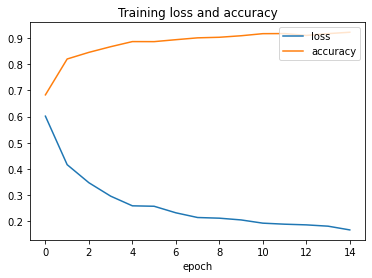

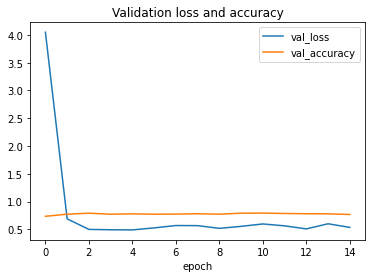

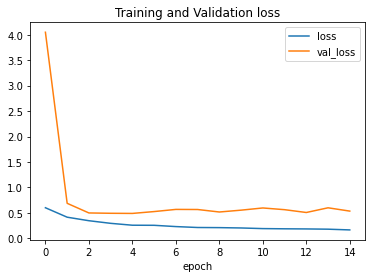

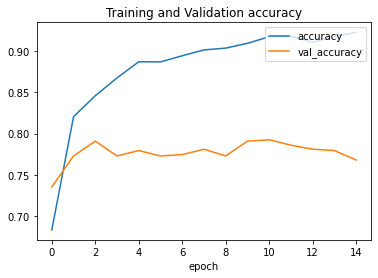

In [51]:
training_fig = plt.figure()
training_fig = plt.figure()
training_ax = training_fig.add_subplot(111)
training_ax.plot(history.history['loss'])
training_ax.plot(history.history['accuracy'])
training_ax.set_title('Training loss and accuracy')
training_ax.set_xlabel('epoch')
training_ax.legend(['loss', 'accuracy'], loc='upper right')

validation_fig = plt.figure()
validation_ax = validation_fig.add_subplot(111)
validation_ax.plot(history.history['val_loss'])
validation_ax.plot(history.history['val_accuracy'])
validation_ax.set_title('Validation loss and accuracy')
validation_ax.set_xlabel('epoch')
validation_ax.legend(['val_loss', 'val_accuracy'], loc='upper right')

tarin_val_loss_fig = plt.figure()
tarin_val_loss_ax = tarin_val_loss_fig.add_subplot(111)
tarin_val_loss_ax.plot(history.history['loss'])
tarin_val_loss_ax.plot(history.history['val_loss'])
tarin_val_loss_ax.set_title('Training and Validation loss')
tarin_val_loss_ax.set_xlabel('epoch')
tarin_val_loss_ax.legend(['loss', 'val_loss'], loc='upper right')

tarin_val_loss_fig = plt.figure()
tarin_val_loss_ax = tarin_val_loss_fig.add_subplot(111)
tarin_val_loss_ax.plot(history.history['accuracy'])
tarin_val_loss_ax.plot(history.history['val_accuracy'])
tarin_val_loss_ax.set_title('Training and Validation accuracy')
tarin_val_loss_ax.set_xlabel('epoch')
tarin_val_loss_ax.legend(['accuracy', 'val_accuracy'], loc='upper right')


plt.show()